In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup

In [3]:
!pip install geocoder
!pip install geopandas
!pip install geopy
import geocoder
import os
!pip install folium
import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


print('Libraries imported successfully.')

     |████████████████████████████████| 102kB 1.0MB/s ta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.
     |████████████████████████████████| 931kB 3.1MB/s eta 0:00:01     |████████████████████████████▎   | 819kB 3.1MB/s eta 0:00:01
     |████████████████████████████████| 14.7MB 26kB/s  eta 0:00:01.4MB 7.6MB/s eta 0:00:02     |██████▌                         | 3.0MB 7.6MB/s eta 0:00:02
     |████████████████████████████████| 1.8MB 19.5MB/s eta 0:00:01
     |████████████████████████████████| 10.9MB 25kB/s  eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.
     |████████████████████████████████| 112kB 4.0MB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
Libraries imported successfully.


In [6]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [4]:
def get_business(lat,lng):
    
    #set variables
    radius=500
    LIMIT=50
    
    CLIENT_ID = 'Z0RFGKZ35UIYB5CK3L0JBBWR5SENDUF1Z02Q3H0DSPBWYETI'
    CLIENT_SECRET = 'KOHOM5YOVKO32ZNGIPXYG3X3UPAS3Z4V1A50Z0AEKMB4UE2D'
    VERSION = '20180605'
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    business_data=results["response"]['groups'][0]['items']
    business_details=[]
    for row in business_data:
        try:
            business_id=row['venue']['id']
            business_name=row['venue']['name']
            business_category=row['venue']['categories'][0]['name']
            business_details.append([business_id,business_name,business_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(business_details,columns=column_names)
    return df

In [5]:
def get_business_details(business_id):
    
    
    CLIENT_ID = '*****'
    CLIENT_SECRET = '*****'
    VERSION = '20180605'

    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            business_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    business_data=results['response']['venue']
    print(business_data)
    business_details=[]
    try:
        business_id=business_data['id']
        business_name=business_data['name']
        business_likes=business_data['likes']['count']
        business_rating=business_data['rating']
        business_tips=business_data['tips']['count']
        business_details.append([business_id,business_name,business_likes,business_rating,business_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(business_details,columns=column_names)
    return df

In [6]:
def get_ny_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    ny_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        ny_data = ny_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return ny_data

In [7]:
ny_data=get_ny_data()

In [8]:
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [9]:
ny_data.shape

(306, 4)

In [10]:
ny_data.to_csv('ny_data_final.csv', index=False)

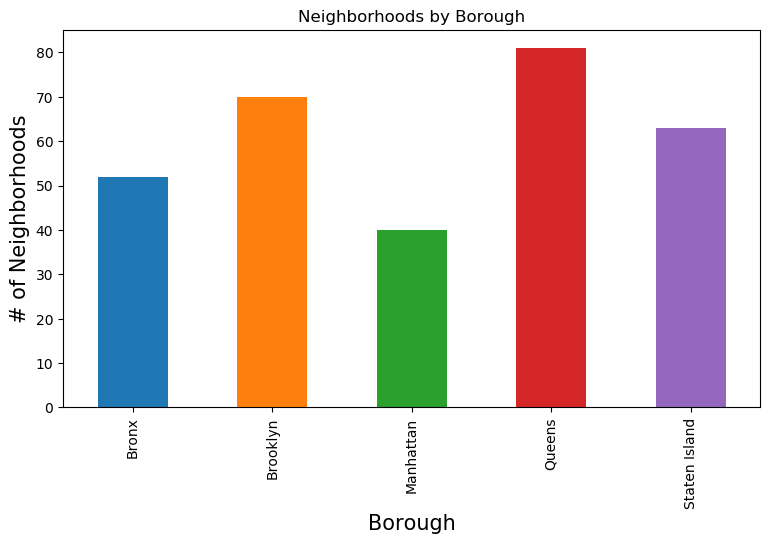

In [11]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Neighborhoods by Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('# of Neighborhoods', fontsize=15)
#giving a bar plot
ny_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
#plt.legend()
#displays the plot
plt.show()

In [28]:
ny_data=pd.read_csv('ny_data_final.csv')

In [29]:
ny_data.shape

(306, 4)

In [43]:
# prepare neighborhood list that contains Italian restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name']
italian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_business(Latitude,Longitude)
    italian_restaurants=venues[venues['Category']=='Italian Restaurant']   
    print('(',count,'/',len(ny_data),')','Italian Restaurants in '+Neighborhood+', '+Borough+':'+str(len(italian_restaurants)))
    for restaurant_detail in italian_restaurants.values.tolist():
        id, name , category=restaurant_detail
        italian_rest_ny = italian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Italian Restaurants in Wakefield, Bronx:0
( 2 / 306 ) Italian Restaurants in Co-op City, Bronx:0
( 3 / 306 ) Italian Restaurants in Eastchester, Bronx:0
( 4 / 306 ) Italian Restaurants in Fieldston, Bronx:0
( 5 / 306 ) Italian Restaurants in Riverdale, Bronx:0
( 6 / 306 ) Italian Restaurants in Kingsbridge, Bronx:0
( 7 / 306 ) Italian Restaurants in Marble Hill, Manhattan:0
( 8 / 306 ) Italian Restaurants in Woodlawn, Bronx:1
( 9 / 306 ) Italian Restaurants in Norwood, Bronx:0
( 10 / 306 ) Italian Restaurants in Williamsbridge, Bronx:0
( 11 / 306 ) Italian Restaurants in Baychester, Bronx:0
( 12 / 306 ) Italian Restaurants in Pelham Parkway, Bronx:2
( 13 / 306 ) Italian Restaurants in City Island, Bronx:1
( 14 / 306 ) Italian Restaurants in Bedford Park, Bronx:0
( 15 / 306 ) Italian Restaurants in University Heights, Bronx:0
( 16 / 306 ) Italian Restaurants in Morris Heights, Bronx:0
( 17 / 306 ) Italian Restaurants in Fordham, Bronx:0
( 18 / 306 ) Italian Restaurants in Ea

In [ ]:
italian_rest_ny.to_csv('italianrestny_final2.csv', index=False)

In [45]:
italian_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Woodlawn,511edb6de4b0d58346fd272d,Patrizia's Of Woodlawn
1,Bronx,Pelham Parkway,4bf96ae65317a593d837017f,Enzo's
2,Bronx,Pelham Parkway,4b47f069f964a5208c4426e3,Pasta Pasta
3,Bronx,City Island,4514ed4df964a520e5391fe3,Artie's Steak and Seafood
4,Bronx,Throgs Neck,4d4456d93616b60c953fe3c2,Tosca Marquee


In [4]:
italian_rest_ny_fromcsv_2=pd.read_csv('italianrestny_final2.csv')

In [5]:
italian_rest_ny_fromcsv_2.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Woodlawn,511edb6de4b0d58346fd272d,Patrizia's Of Woodlawn
1,Bronx,Pelham Parkway,4bf96ae65317a593d837017f,Enzo's
2,Bronx,Pelham Parkway,4b47f069f964a5208c4426e3,Pasta Pasta
3,Bronx,City Island,4514ed4df964a520e5391fe3,Artie's Steak and Seafood
4,Bronx,Throgs Neck,4d4456d93616b60c953fe3c2,Tosca Marquee


In [6]:
italian_rest_ny_fromcsv_2.shape

(229, 4)

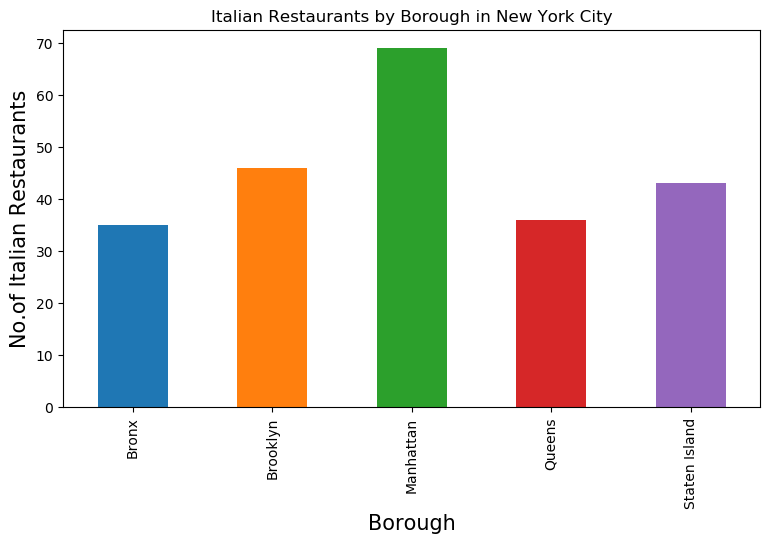

In [7]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Italian Restaurants by Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Italian Restaurants', fontsize=15)
#giving a bar plot
italian_rest_ny_fromcsv_2.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
#plt.legend()
#displays the plot
plt.show()

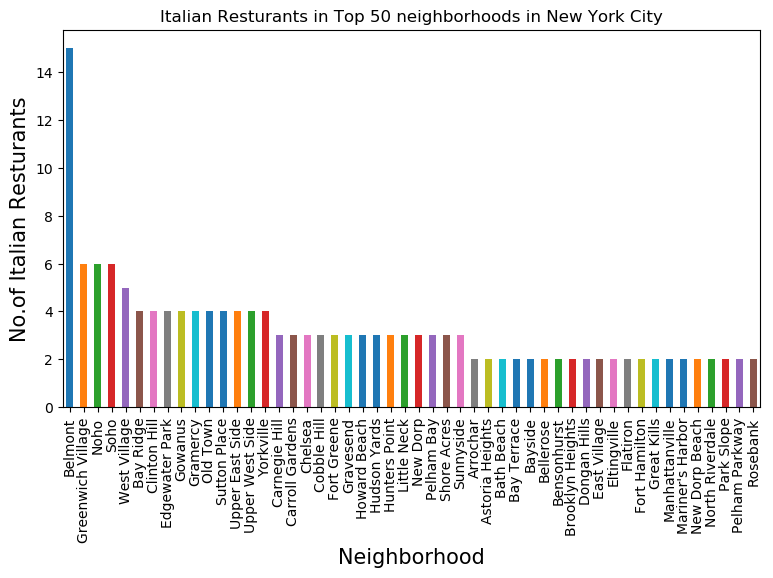

In [8]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Italian Resturants in Top 50 neighborhoods in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Italian Resturants', fontsize=15)
#giving a bar plot
italian_rest_ny_fromcsv_2.groupby('Neighborhood')['ID'].count().nlargest(50).plot(kind='bar')
#legend
#plt.legend()
#displays the plot
plt.show()

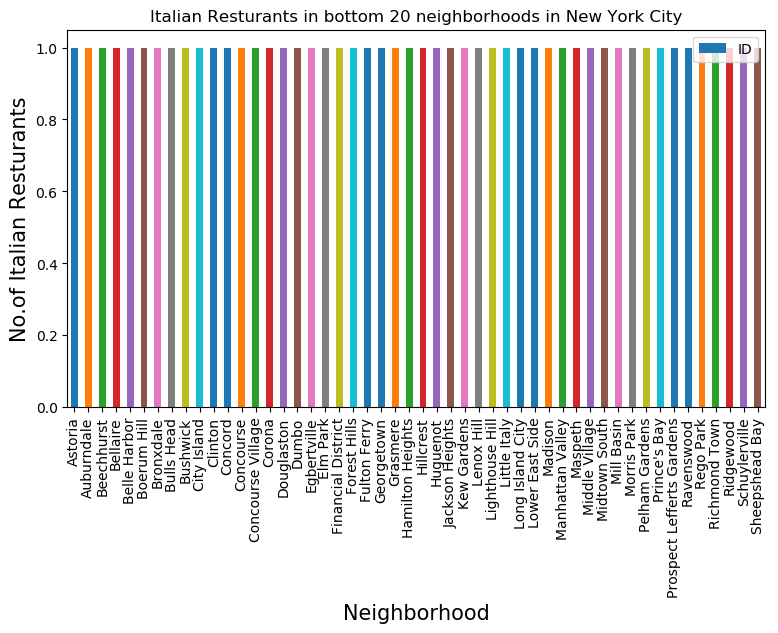

In [9]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Italian Resturants in bottom 20 neighborhoods in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Italian Resturants', fontsize=15)
#giving a bar plot
italian_rest_ny_fromcsv_2.groupby('Neighborhood')['ID'].count().nsmallest(50,keep='first').plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In the following steps, the 229 italian restaurants are split into 5 files to process 50 at a time with the Foursquare API premium calls. 
Then the output is comibined to create one CSV files for visualization.

In [13]:
#italian_rest_ny_fromcsv=pd.read_csv('italianrest_ny_1.csv')

In [16]:
#italian_rest_ny_fromcsv=pd.read_csv('italianrest_ny_2.csv')

In [28]:
#italian_rest_ny_fromcsv=pd.read_csv('italianrest_ny_3.csv')

In [39]:
#italian_rest_ny_fromcsv=pd.read_csv('italianrest_ny_4.csv')

In [50]:
italian_rest_ny_fromcsv=pd.read_csv('italianrest_ny_5.csv')

In [51]:
italian_rest_ny_fromcsv.head()

,Borough,Neighborhood,ID,Name
0,Staten Island,Shore Acres,4b63728ff964a5208d7a2ae3,Angie's Pizza & Restaurant
1,Staten Island,Concord,4c07011e0e0a2d7ff9c7ec0c,Venezia
2,Staten Island,Elm Park,4d51deac3062a1cd37786ba3,Bella Mama Rose Italian Restaurant
3,Brooklyn,Mill Basin,4c267153b012b71350e30893,Landi's Pork Store
4,Queens,Astoria Heights,4f048814f9ab88b0c268dda3,Antonio's Kitchen


In [52]:
italian_rest_ny_fromcsv.shape

(29, 4)

In [53]:
# Get the business details -Likes, Rating and Tips for each Italian Restaurant from the list.

#Due to the limits(50 per day) on the Premium API calls from Foursquare, italianrestny_final.csv was split into four parts and
# the following code is run four times to get details and merge all the data to create italianrest_stats_ny_final.csv.
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
italian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in italian_rest_ny_fromcsv.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        business_details=get_business_details(ID)
        #print(business_details)
        id,name,likes,rating,tips=business_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(italian_rest_ny_fromcsv),')','processed')
    italian_rest_stats_ny = italian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

{'id': '4b63728ff964a5208d7a2ae3', 'name': "Angie's Pizza & Restaurant", 'contact': {'phone': '7188167211', 'formattedPhone': '(718) 816-7211'}, 'location': {'address': '1377 Bay St', 'crossStreet': 'Evelyn Pl & Bay Street', 'lat': 40.610118, 'lng': -74.06298199999999, 'labeledLatLngs': [{'label': 'display', 'lat': 40.610118, 'lng': -74.06298199999999}, {'label': 'entrance', 'lat': 40.610102, 'lng': -74.063047}], 'postalCode': '10305', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1377 Bay St (Evelyn Pl & Bay Street)', 'Staten Island, NY 10305', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/angies-pizza--restaurant/4b63728ff964a5208d7a2ae3', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d1ca

In [54]:
italian_rest_stats_ny.shape

(29, 7)

In [55]:
#write output to a csv file.
italian_rest_stats_ny.to_csv('italianrest_stats_5.csv', index=False)

In [ ]:
# to verify that the data is written to the file.
datafromcsv = pd.read_csv('italianrest_stats_5.csv')

In [ ]:
datafromcsv.shape

In [58]:
datafromcsv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Staten Island,Shore Acres,0,0,0,0.0,0
1,Staten Island,Concord,0,0,0,0.0,0
2,Staten Island,Elm Park,4d51deac3062a1cd37786ba3,Bella Mama Rose Italian Restaurant,6,6.7,10
3,Brooklyn,Mill Basin,4c267153b012b71350e30893,Landi's Pork Store,32,8.7,11
4,Queens,Astoria Heights,4f048814f9ab88b0c268dda3,Antonio's Kitchen,15,7.1,12


Now, Merge the output of the all the stats files into one single csv file.

In [7]:
italianrest_stats_ny_final = pd.read_csv('italianrest_stats_ny_final2.csv')

In [8]:
italianrest_stats_ny_final.shape

(229, 7)

In [9]:
italianrest_stats_ny_final.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,511edb6de4b0d58346fd272d,Patrizia's Of Woodlawn,18,8.3,14
1,Bronx,Pelham Parkway,4bf96ae65317a593d837017f,Enzo's,26,8.7,11
2,Bronx,Pelham Parkway,4b47f069f964a5208c4426e3,Pasta Pasta,9,6.4,8
3,Bronx,City Island,4514ed4df964a520e5391fe3,Artie's Steak and Seafood,44,8.3,27
4,Bronx,Throgs Neck,4d4456d93616b60c953fe3c2,Tosca Marquee,19,6.9,14


Convert datatype for Likes and Tips From String to Float

In [10]:
italianrest_stats_ny_final['Likes']=italianrest_stats_ny_final['Likes'].astype('float64')
italianrest_stats_ny_final['Tips']=italianrest_stats_ny_final['Tips'].astype('float64')

Now we will find the Italian restuarants with Maximum Likes, Maximum Ratings and Maximum Tips.

In [11]:
italianrest_stats_ny_final.iloc[italianrest_stats_ny_final['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                        Soho
ID              4cc6222106c25481d7a4a047
Name                 Rubirosa Ristorante
Likes                               2491
Rating                               9.3
Tips                                 824
Name: 108, dtype: object

In [12]:
italianrest_stats_ny_final.iloc[italianrest_stats_ny_final['Rating'].idxmax()]

Borough                         Brooklyn
Neighborhood                    Bushwick
ID              5a98aed16a59506d7a60d67c
Name                        Carmenta‚Äôs
Likes                                 56
Rating                               9.5
Tips                                  21
Name: 46, dtype: object

In [13]:
italianrest_stats_ny_final.iloc[italianrest_stats_ny_final['Tips'].idxmax()]

Borough                    Staten Island
Neighborhood               West Brighton
ID              4b5b58dbf964a52088f628e3
Name                        Panini Grill
Likes                                 21
Rating                               8.6
Tips                                1136
Name: 157, dtype: object

Visualize neighborhood with maximum average rating.

In [14]:
ny_neighborhood_stats=italianrest_stats_ny_final.groupby(['Neighborhood'],as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [15]:
ny_neighborhood_stats.shape

(114, 2)

In [16]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(25)

,Neighborhood,Average Rating
18,Bushwick,9.500000
14,Boerum Hill,9.100000
51,Hamilton Heights,9.000000
101,Tribeca,8.900000
50,Greenwich Village,8.866667
93,Soho,8.866667
110,Windsor Terrace,8.800000
15,Bronxdale,8.800000
24,Clinton Hill,8.750000
44,Georgetown,8.700000


Similarly we will find the average rating of Italian Resturants for each Borough.

In [17]:
ny_borough_stats=italianrest_stats_ny_final.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [18]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.476812
0,Bronx,7.828571
1,Brooklyn,7.804348
3,Queens,7.041667
4,Staten Island,5.176744


Visualize the data

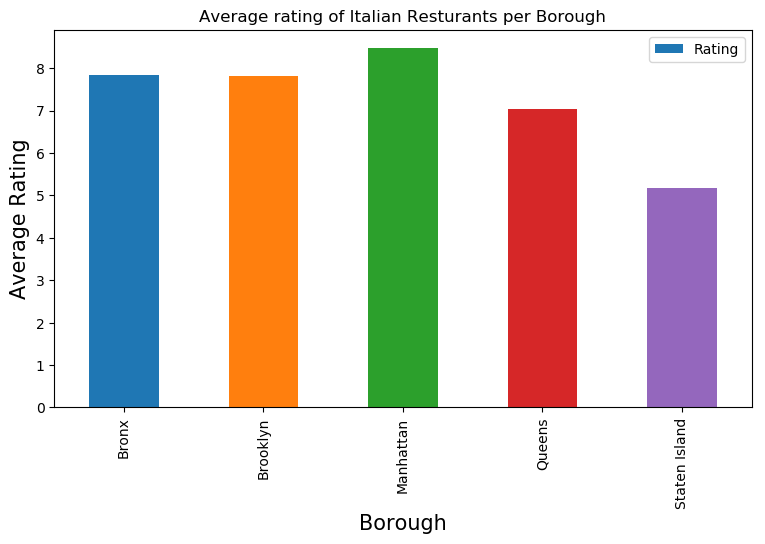

In [19]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Italian Resturants per Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
italianrest_stats_ny_final.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

Let us consider all the neighborhoods with average rating greater or equal 8.5

In [20]:
ny_neighborhood_stats.shape

(114, 2)

In [21]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.5]

In [22]:
ny_neighborhood_stats.shape

(26, 2)

In [23]:
ny_neighborhood_stats.head()

,Neighborhood,Average Rating
9,Bellaire,8.60
14,Boerum Hill,9.10
15,Bronxdale,8.80
16,Brooklyn Heights,8.65
18,Bushwick,9.50


In [24]:
print(ny_neighborhood_stats)

                  Neighborhood  Average Rating
9                     Bellaire        8.600000
14                 Boerum Hill        9.100000
15                   Bronxdale        8.800000
16            Brooklyn Heights        8.650000
18                    Bushwick        9.500000
24                Clinton Hill        8.750000
29                      Corona        8.700000
39                    Flatiron        8.500000
44                  Georgetown        8.700000
50           Greenwich Village        8.866667
51            Hamilton Heights        9.000000
57             Jackson Heights        8.600000
61                Little Italy        8.700000
64             Lower East Side        8.500000
71               Midtown South        8.500000
72                  Mill Basin        8.700000
73                 Morris Park        8.600000
76                        Noho        8.650000
81              Pelham Gardens        8.500000
84   Prospect Lefferts Gardens        8.500000
86           

Visualize Ratings by Neighborhood.


In [25]:
ny_toprating_stats = ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.5]

In [26]:
ny_toprating_stats.shape

(26, 2)

In [30]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')

In [31]:

ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [44]:
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Queens,Bellaire,40.733014,-73.738892,8.600000
1,Brooklyn,Boerum Hill,40.685683,-73.983748,9.100000
2,Brooklyn,Brooklyn Heights,40.695864,-73.993782,8.650000
3,Brooklyn,Bushwick,40.698116,-73.925258,9.500000
4,Manhattan,Chelsea,40.744035,-74.003116,8.600000
5,Staten Island,Chelsea,40.594726,-74.189560,8.600000
6,Brooklyn,Clinton Hill,40.693229,-73.967843,8.750000
7,Queens,Corona,40.742382,-73.856825,8.700000
8,Brooklyn,Georgetown,40.623845,-73.916075,8.700000
9,Manhattan,Greenwich Village,40.726933,-73.999914,9.100000


In [32]:
ny_neighborhood_stats.to_csv('ny_neighborhood_stats_final2.csv')

In [33]:
#Read data from the csv file.
ny_neighborhood_stats=pd.read_csv('ny_neighborhood_stats_final2.csv')

In [34]:
ny_neighborhood_stats.shape

(26, 6)

In [38]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

In [40]:
# instantiate a feature group 
incidents = folium.FeatureGroup(name="My Map")

# loop through the neighborhood and each location to the feature group and then add the feature group to the map.
for lat, lng, neighborhood, borough, avgrating in ny_neighborhood_stats[['Latitude','Longitude','Borough','Neighborhood','Average Rating']].values:
    incidents.add_child(folium.CircleMarker(location=[lat, lng], radius = 100,color='blue', popup=neighborhood+' '+borough +'  ' + str(avgrating)))

ny_map.add_child(incidents)

In [37]:
ny_map.save('neighborhood_2.html')

In [75]:
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Queens,Bellaire,40.733014,-73.738892,8.600000
1,Brooklyn,Boerum Hill,40.685683,-73.983748,9.100000
2,Brooklyn,Brooklyn Heights,40.695864,-73.993782,8.650000
3,Brooklyn,Bushwick,40.698116,-73.925258,9.500000
4,Manhattan,Chelsea,40.744035,-74.003116,8.600000
5,Staten Island,Chelsea,40.594726,-74.189560,8.600000
6,Brooklyn,Clinton Hill,40.693229,-73.967843,8.750000
7,Queens,Corona,40.742382,-73.856825,8.700000
8,Brooklyn,Georgetown,40.623845,-73.916075,8.700000
9,Manhattan,Greenwich Village,40.726933,-73.999914,9.100000
